# MNIST classification using persistent homology and vectorizations

In this notebook, we apply TDA to the MNIST dataset consisting of handwritten digits for classification. This notebook borrows heavily from the `giotto-tda` tutorial notebook [Classifying handwritten digits](https://giotto-ai.github.io/gtda-docs/0.4.0/notebooks/MNIST_classification.html), except for some slight modifications in the beginning and the end. I strongly encourage you to check out all that `giottto-tda` has to offer, and especially read the [giotto-tda documentation](https://giotto-ai.github.io/gtda-docs/0.4.0/index.html).

The MNIST dataset consists of 70,000 handwritten digits, stored as grey scale images of 28 x 28 pixels. We will build a classifier to predict which digit is written from the image. See [The MNIST Database of Handwritten Digits](http://yann.lecun.com/exdb/mnist/) by Yann LeCun, Corinna Cortes, and Christopher J.C. Burges for more details. 

For a more in-depth study of look at the basic pipeline outlined here, see [A Topological "Reading" Lesson: Classification of MNIST using TDA](https://arxiv.org/abs/1910.08345) by Adélie Garin and Guillaume Tauzin.

### Load the dataset, binarize, split into training and test sets

In [62]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

In [63]:
X.shape, y.shape

((70000, 784), (70000,))

So we do indeed have 70,000 images, each of which has 784 = 28 * 28 pixels. Let's check out a digit to make sure things work the way we think.

(-0.5, 27.5, 27.5, -0.5)

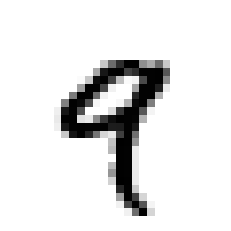

In [64]:
import matplotlib.pyplot as plt
digit = X[4].reshape(28,28)

plt.imshow(digit, cmap = 'binary')
plt.axis('off')

I guess that looks like a 9. Is it?

In [65]:
y[4]

9

We choose the same threshold as the [Garin et al] paper and see what the binarized digit looks like.

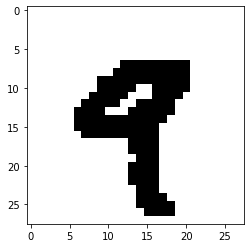

In [66]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.4)
digit_bin = binarizer.fit_transform(digit)

plt.imshow(digit_bin, cmap='binary')

Finally, we're ready to split the data into a training set and a test set.

In [67]:
from sklearn.model_selection import train_test_split

train_size, test_size = 600, 100

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (600, 28, 28), y_train shape: (600,)
X_test shape: (100, 28, 28), y_test shape: (100,)


### Pipeline

The following pipeline can be a bit much if you're new to data science and TDA, so lets step through the entire pipeline using our binarized digit `digit`. We will think of the digit as a _cubical complex_ $C$ and build a filtration of the digit using various filtrations discussed earlier. 

The _height filtration_ is determined by a _height_ function $h : C \times S^{1} \to \mathbb{R}$, assigning to each voxel, direction pair $(c,\theta)$ the distance from the first seen edge (hyperplane) of $C$ in the direction of $\theta$ to $c$. Typically we fix the direction $\theta$ and use $h_{\theta} : C \to \mathbb{R}$ to construct the filtration. If $v$ is a unit vector pointing in the direction of $\theta$, then $h_{\theta}(c) = \langle c ,v \rangle$. Thus $\mathcal{F}_{\theta}(r) = \{ c | h(c,\theta) \leq r \}$.

The _radial filtration_ is determined by a _radial_ function $r : C \times C \to \mathbb{R}$, assigning to each voxel, 'center' pairs $(c,\rho)$ the distance from $c$ to $\rho$. Again, this is a function of the 'center' point $\rho$, which we fix and use $r_{\rho} : C \to \mathbb{R}$. If a voxel $v$ is not in the binarized image, we set $r_{\rho}(v) = r_{\infty}$, the maximum value of $r_{\rho}$. Note that this function also depends on how we measure 'distance', but for this code, we'll use either the $L_1$ or $L_2$ norm of the difference.

Let's try these out for the binarized digit we've been working with.

In [68]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([5,25]))
digit_rad_filtration = radial_filtration.fit_transform_plot(digit_bin[None,:,:],colorscale='Viridis')

In [69]:
from gtda.images import HeightFiltration

height_filtration = HeightFiltration(direction=np.array([1,0]))
digit_height_filtration = height_filtration.fit_transform_plot(digit_bin[None,:,:], colorscale='Viridis')

The next step is to use either of these filtrations to compute the corresponding persistent homology.

In [70]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
digit_height_persistence = cubical_persistence.fit_transform_plot(digit_height_filtration)

In [71]:
digit_height_persistence

array([[[13., 14.,  0.],
        [16., 28.,  1.]]])

Now its time for vectorization.

In [72]:
from gtda.diagrams import Scaler

scaler = Scaler()
digit_scaled = scaler.fit_transform(digit_height_persistence)

scaler.plot(digit_scaled)

In [73]:
digit_scaled

array([[[2.16666667, 2.33333333, 0.        ],
        [2.66666667, 4.66666667, 1.        ]]])

In [74]:
from gtda.diagrams import PersistenceLandscape

pl = PersistenceLandscape(n_bins = 100)
digit_pl = pl.fit_transform(digit_scaled)

pl.plot(digit_pl)

In [75]:
from gtda.diagrams import Amplitude

digit_amp = Amplitude(metric="landscape")
digit_amp.fit_transform(digit_scaled)

array([[0.01964085, 0.81645493]])

In [76]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
digit_heat = heat.fit_transform(digit_scaled)

# Visualise the heat kernel for H1
heat.plot(digit_heat, homology_dimension_idx=1, colorscale='Viridis')

The final step in our pipeline is to take the 'Amplitude' or $L_p$ norm of each vectorization in each homological degree. The Amplitude is a vector $\vec{a}=(a_0,a_1,\ldots)$ where each $a_i$ is the $L_p$ norm of the chosen vectorization scheme in homological degree $i$.

### Automation

We combine all of the different filtrations, vectorization schemes, and amplitudes to make one final pipeline. This is taken directly from 

In [81]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from gtda.images import Binarizer

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [82]:
from sklearn import set_config
set_config(display='diagram')  

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 PersistenceEntrop...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [83]:
X_train.shape

(600, 28, 28)

In [84]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(600, 476)

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
rf.score(X_test_tda, y_test)

0.86

How can we improve this classification? W can try to reduce some of the 476 topological features used here. By loooking at the correlation between the features, we can remove highly correlated features and reduce the complexity of the model, also improving efficiency. We could also try other ML algorithms besides Random Forests like SVM, clustering, etc.